In [1]:
# pip install pydicom

In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm
import seaborn as sns
import pydicom as dcm
#from google.colab import drive
%matplotlib inline 
IS_LOCAL = False
import os


In [3]:
#drive.mount('/content/my-drive')


In [4]:
#!ls '/content/my-drive/My Drive'

In [5]:
#class_info_df = pd.read_csv('/content/my-drive/My Drive/stage_2_detailed_class_info.csv')
#train_labels_df = pd.read_csv('/content/my-drive/My Drive/stage_2_train_labels.csv')      

class_info_df = pd.read_csv('stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv('stage_2_train_labels.csv')    

In [6]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [7]:
class_info_df.sample(10)

,patientId,class
11448,76feb952-4a70-4918-8a8d-881eb14bdcbe,Normal
18056,ab5af9ff-8001-4442-af29-693abdb98e14,Lung Opacity
14204,8cf63742-b23b-43e9-8834-ec72713cb33f,Normal
2144,280bb7b4-408c-46c4-b0e8-a681722421c9,No Lung Opacity / Not Normal
10761,719bb18b-a428-4fd8-9338-46f1187ffa5c,Lung Opacity
22865,ce3a5775-4473-4dd0-a9b8-6ad1583e2223,No Lung Opacity / Not Normal
24573,dccf4ea8-192f-4749-91e5-63defbc74f29,Normal
8059,5c3d2e98-56df-408d-a597-359fb4115cc0,No Lung Opacity / Not Normal
5474,4713b1ea-ff00-4443-afc2-8a6117cb9bd2,No Lung Opacity / Not Normal
21656,c4a2f14a-82dc-49fc-aa03-037bf6b99c6c,No Lung Opacity / Not Normal


In [8]:
train_labels_df.sample(10)

,patientId,x,y,width,height,Target
10509,6fa64f88-7577-402b-a184-81bd235babfe,NaN,NaN,NaN,NaN,0
20571,bc114b89-421f-4cc2-88a3-721ff2b2ea54,NaN,NaN,NaN,NaN,0
8049,5c2f7b91-5a92-483e-a028-4b64e9152a06,NaN,NaN,NaN,NaN,0
13431,87233f70-c512-4a6b-8ece-a4cb41accb66,285.0,405.0,140.0,223.0,1
17836,a9a642d7-a47b-40d9-ba5b-0d84223026cd,NaN,NaN,NaN,NaN,0
5664,48a74e9c-c0bb-4eeb-85f7-6ca980152001,NaN,NaN,NaN,NaN,0
27392,f33f9fff-1560-4ee7-8d8e-35de9bf457f2,NaN,NaN,NaN,NaN,0
27524,f468acf0-c324-44c8-b60f-65bb2ca843c5,NaN,NaN,NaN,NaN,0
14809,91b2ce38-efaf-4476-b77c-4f363d340f11,172.0,487.0,300.0,258.0,1
21033,beee42c2-9e3d-4fd9-a3ba-255743268904,NaN,NaN,NaN,NaN,0


In [9]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))

missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [10]:
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


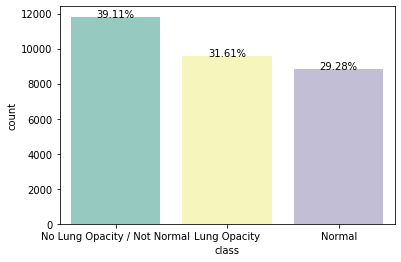

In [11]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [12]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [13]:
train_class_df.sample(5)

,patientId,x,y,width,height,Target,class
5920,3d2acab8-4160-4aa6-8071-4ab0fa1313ef,596.0,343.0,176.0,228.0,1,Lung Opacity
37588,c145df8e-9631-468d-af7f-5690c11c2c88,601.0,265.0,173.0,383.0,1,Lung Opacity
17736,8cf9fffd-08ef-448b-b9ec-1074d9e5691e,141.0,428.0,256.0,302.0,1,Lung Opacity
29311,d0b837a5-6a44-48cd-8feb-e7550e3b6ed9,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
7303,4574b254-3494-4530-bb8d-b3a80b14fff6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [14]:
# All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.
# The chest examinations with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal.

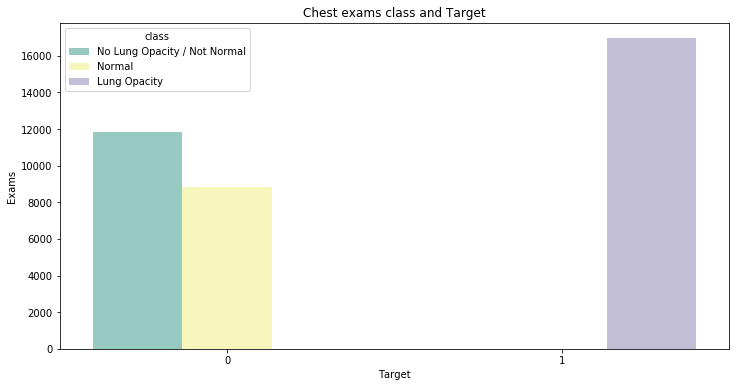

In [15]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

In [16]:
## Explore DICOM data

<Figure size 432x288 with 0 Axes>

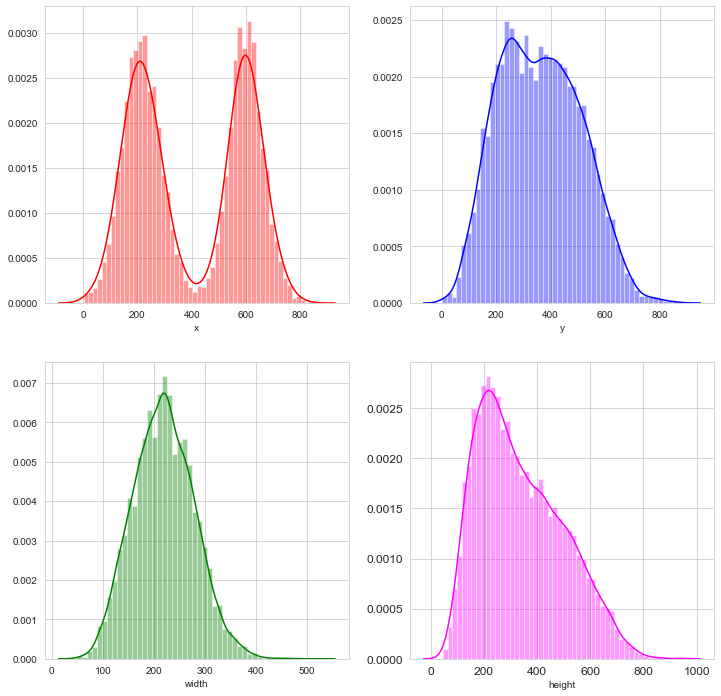

In [17]:
target1 = train_class_df[train_class_df['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

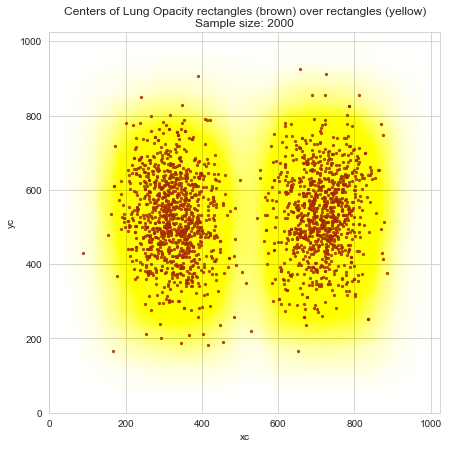

In [18]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
target_sample = target1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title("Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000")
target_sample.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0,1024), ax=ax, alpha=0.8, marker=".", color="brown")
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

In [19]:
#img_path='/content/my-drive/My Drive/rsna-pneumonia-detection-challenge.zip (Unzipped Files)'
#image_sample_path = os.listdir(img_path+'/stage_2_train_images')[:5]
image_sample_path = os.listdir('stage_2_train_images')[:5]
print(image_sample_path)

['0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', '000924cf-0f8d-42bd-9158-1af53881a557.dcm', '000db696-cf54-4385-b10b-6b16fbb3f985.dcm', '000fe35a-2649-43d4-b027-e67796d412e0.dcm', '001031d9-f904-4a23-b3e5-2c088acd19c6.dcm']


In [20]:
#image_train_path = os.listdir(img_path+'/stage_2_train_images')
#image_test_path = os.listdir(img_path+'/stage_2_test_images')

image_train_path = os.listdir('stage_2_train_images')
image_test_path = os.listdir('stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


In [21]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())      

Unique patientId in  train_class_df:  26684


In [22]:
## DICOM METADATA

samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join("stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [23]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        #imagePath = os.path.join(img_path,"stage_2_train_images/",patientImage)
        imagePath = os.path.join("stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

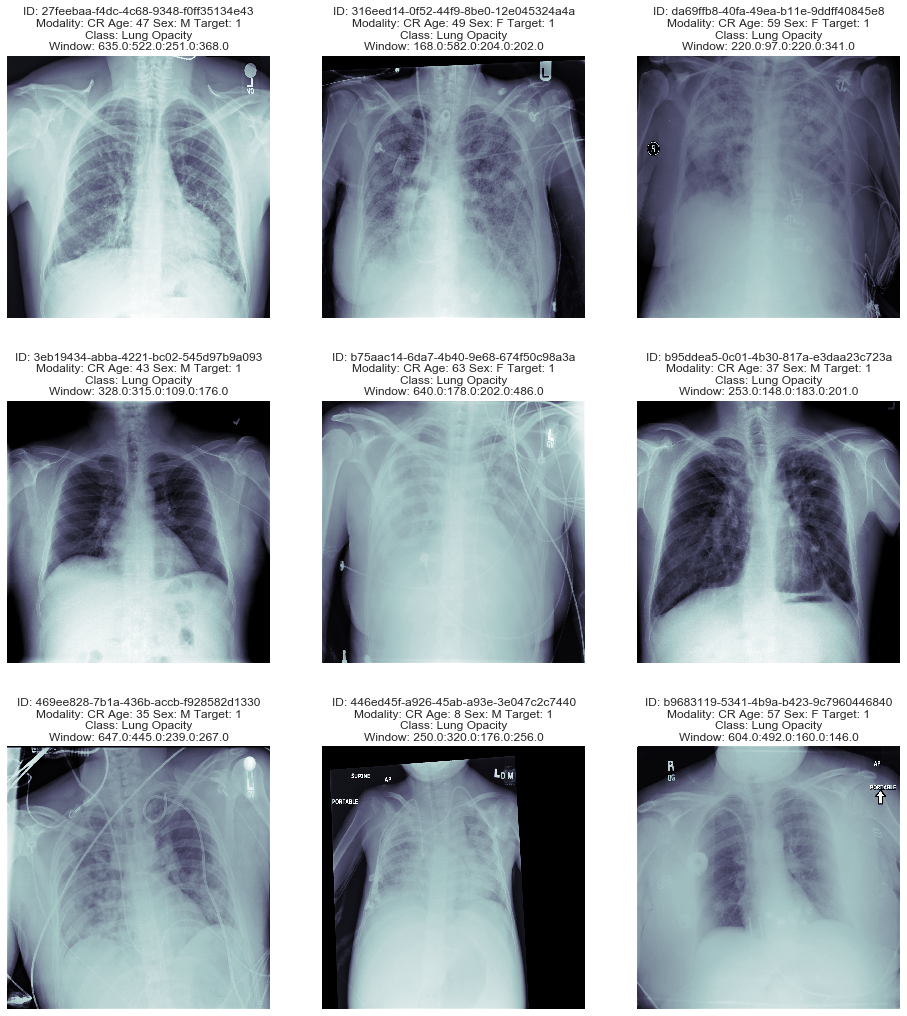

In [24]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

In [25]:
## Add meta information from DICOM data
## TRAIN data

In [28]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    #image_names = os.listdir(img_path+'/'+data_path)
    image_names = os.listdir(data_path)
    for i, img_name in tqdm(enumerate(image_names)):
        #imagePath = os.path.join(img_path,data_path,img_name)
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 

In [29]:
process_dicom_data(train_class_df,'stage_2_train_images/')

In [31]:
print(train_class_df.columns)

Index(['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'Modality',
       'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition',
       'ConversionType', 'Rows', 'Columns', 'PixelSpacing'],
      dtype='object')


In [34]:
test_class_df = test_class_df.drop('PredictionString',1)
process_dicom_data(test_class_df,'stage_2_test_images/')

In [37]:
test_class_df.columns

Index(['patientId', 'PredictionString'], dtype='object')

In [35]:
final_train_class_df= pd.DataFrame(train_class_df, 
                                   columns = ['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'Modality',
                                              'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition',
                                              'ConversionType', 'Rows', 'Columns', 'PixelSpacing'])

final_train_class_df.to_excel(r'C:\\temp\\final_train_class_df.xlsx', index = False, header=True)

In [38]:
final_test_class_df= pd.DataFrame(test_class_df, 
                                   columns = ['patientId','PredictionString'])

final_test_class_df.to_excel(r'C:\\temp\\final_test_class_df.xlsx', index = False, header=True)